# A rough spellchecker on Brazilian Portuguese

This notebook is an attempt to create a very simple brazilian-portuguese spellchecker. It's inspired on [Peter Norvig's](https://norvig.com/) [famous essay](https://norvig.com/spell-correct.html) on the subject and follows the same logic of [this](https://nbviewer.org/url/norvig.com/ipython/How%20to%20Do%20Things%20with%20Words.ipynb) notebook of his.

In [1]:
%pylab inline
import re
import math
import string
from collections import Counter
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


I start with a big .txt file, a collection of many books.

In [27]:
big = open("big2.txt").read()

In [28]:
len(big)

1278839

it's made up of 12.8 million characters. How many words are there?

In [29]:
def tokens(text):
    "a list of all word tokens (consecutive letters bundled together)"
    return re.findall('[a-z_À-ÿ]+', text.lower())

In [30]:
tokens('testing: to see, if this 1 2 works')

['testing', 'to', 'see', 'if', 'this', 'works']

In [32]:
WORDS = tokens(big)
len(WORDS)

205713

1.72 million words, the first 10 being:

In [33]:
WORDS[:10]

['resultados',
 'da',
 'procura',
 'de',
 'novembro',
 'de',
 'procura',
 'a',
 'pedido',
 'de']

Now we make a ```Counter``` for the ```WORDS``` list

In [34]:
COUNTS = Counter(WORDS)
COUNTS.most_common(10)

[('a', 17184),
 ('de', 9309),
 ('par', 7774),
 ('o', 5067),
 ('que', 4539),
 ('e', 4251),
 ('do', 3749),
 ('b', 3165),
 ('da', 3096),
 ('em', 2312)]

In [9]:
for w in tokens('haja palavra rara nesse textão aí'):
    print (COUNTS[w], w)

41 haja
198 palavra
7 rara
862 nesse
0 textão
92 aí


Here is a formulation of [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law):

_"given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table."_

Since we have a big file of PTB utterances, Let's test the law to see if it holds:

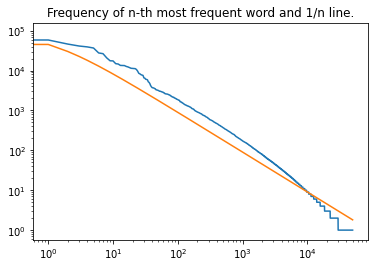

In [10]:
M = COUNTS['de']
yscale('log'); xscale('log'); title('Frequency of n-th most frequent word and 1/n line.')
plot([c for (w,c) in COUNTS.most_common()])
plot([M/i for i in range(1, len(COUNTS)+1)]);
     
     

# Spelling Correction

given a word w, find the most likely correction c= ```correct(w)```.

The idea is to get a list of all candidates ```c``` that are known words and that are near w.

"near" means either one edit away or two edits away.\
"likely" is defined by the ```WORDS``` count of any given word.

Let us write these functions:

In [11]:
def correct(word):
    "find the best spelling correction for a word"
    # Prefer edit distance 0, then 1, then 2; otherwise default to word itself.
    candidates = (known(edits0(word)) or
                  known(edits1(word)) or
                  known(edits2(word)) or
                  [word])
    return max(candidates, key=COUNTS.get)

we'll leave the ```edits1``` function for a bit later...

In [12]:
def known(words):
    "return the subset of words that are in the dictionary"
    return {w for w in words if w in COUNTS}

def edits0(word):
    "return all strings zero edits away from word"
    return {word}

def edits2(word):
    "return all strings two edits away from word"
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}
    

For ```edit1(word)``` we'll need to imput the edits themselves. For a PTB example, the word \*"oato" would include the following edits:

"boato" _rumour_, through **insertion**\
"ato" _act_, through **deletion**\
"pato" _duck_, through **replacement**\
\*"aoto", through **transposition** 

To implement these edits, we'll break the original word into pairs at every possible place, and at each place we'll either insert, delete, replace or transpose a leter:


|          |          |          |      |          |          |           |
| -------- | -------- |--------- |------|--------- |--------- | --------- |
| pairs:   | Ø+oato    | o+ato   | oa+to | oat+o    | oato+Ø | *notes: (a,b) pair*
| deletions: | Ø+ato   | o+to    | oa+o  |  oat+Ø  |         | *delete first char of b*
| transpositions: | Ø+oato   | o+tao    | oa+ot  |        |         | *swap first two chars of b*
| replacements: | Ø+?ato   | o+?to    | oa+?o  |  oat+?  |         | *replace chat at start of b*
| insertions: | Ø+?+oato   | o+?+ato | oa+?+to  |  oat+?+o  | oato+?+Ø| *insert char between a and b*


In [13]:
def edits1(word):
    "return all strings that are one edit away from this word"
    pairs      = splits(word)
    deletes    = [a+b[1:]            for (a, b) in pairs if b] 
    transposes = [a+b[1]+b[0]+b[2:]  for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]          for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b              for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "return a list of all possible (first, rest) pairs that comprises word."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyzçéíáàóãüôê'

In [14]:
splits('oato')

[('', 'oato'), ('o', 'ato'), ('oa', 'to'), ('oat', 'o'), ('oato', '')]

In [15]:
edits0('oato')

{'oato'}

In [16]:
edits1('oato')

{'aato',
 'aoato',
 'aoto',
 'ato',
 'bato',
 'boato',
 'cato',
 'coato',
 'dato',
 'doato',
 'eato',
 'eoato',
 'fato',
 'foato',
 'gato',
 'goato',
 'hato',
 'hoato',
 'iato',
 'ioato',
 'jato',
 'joato',
 'kato',
 'koato',
 'lato',
 'loato',
 'mato',
 'moato',
 'nato',
 'noato',
 'oaao',
 'oaato',
 'oabo',
 'oabto',
 'oaco',
 'oacto',
 'oado',
 'oadto',
 'oaeo',
 'oaeto',
 'oafo',
 'oafto',
 'oago',
 'oagto',
 'oaho',
 'oahto',
 'oaio',
 'oaito',
 'oajo',
 'oajto',
 'oako',
 'oakto',
 'oalo',
 'oalto',
 'oamo',
 'oamto',
 'oano',
 'oanto',
 'oao',
 'oaoo',
 'oaot',
 'oaoto',
 'oapo',
 'oapto',
 'oaqo',
 'oaqto',
 'oaro',
 'oarto',
 'oaso',
 'oasto',
 'oat',
 'oata',
 'oatao',
 'oatb',
 'oatbo',
 'oatc',
 'oatco',
 'oatd',
 'oatdo',
 'oate',
 'oateo',
 'oatf',
 'oatfo',
 'oatg',
 'oatgo',
 'oath',
 'oatho',
 'oati',
 'oatio',
 'oatj',
 'oatjo',
 'oatk',
 'oatko',
 'oatl',
 'oatlo',
 'oatm',
 'oatmo',
 'oatn',
 'oatno',
 'oato',
 'oatoa',
 'oatob',
 'oatoc',
 'oatod',
 'oatoe',
 'oato

In [17]:
len(edits1('oato'))

324

In [23]:
len(edits2('oato'))

46903

In [21]:
list(map(correct, tokens()))

['pour']